In [10]:
import pandas as pd
import prisma_ml as prisma
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [11]:
df = pd.read_csv(r"../../data/processed/emotet_static.csv")

## EDA

In [12]:
info = prisma.DatasetInformation(df)

info.dataframe_summary()

### Shape:

(79667, 31)

### Columns and Metadata:

,Data Type,Null Values,Percentage of Nulls
Duration,float64,0,0.0
Source Port,int64,0,0.0
Destination Port,int64,0,0.0
Protocol,object,0,0.0
Flags,object,0,0.0
Packets,int64,0,0.0
Bytes,int64,0,0.0
Mean Payload Size,float64,0,0.0
Std Payload Size,float64,0,0.0
Min Payload Size,int64,0,0.0


### Duplicated Rows:

,Duplicated Rows Count
Total,23


### Categorical

In [13]:
info = prisma.DatasetInformation(df)

info.categorical_summary()

### Categorical Columns Summary:

,Column,Unique Values Count,Top Value,Top Value Percentage
0,Protocol,4,TCP,76.17%
1,Flags,14,SYN,51.51%
2,Label,2,Benign,53.88%
3,Direction,1,outbound,100.00%


### Column: Protocol

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,TCP,60684,76.172066
1,HTTP,14216,17.844277
2,DATA-TEXT-LINES,4743,5.953532
3,XML,24,0.030125


---

### Column: Flags

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,SYN,41036,51.509408
1,"PSH,ACK",18926,23.756386
2,"FIN,SYN,ACK",9294,11.666060
3,"SYN,RST,ACK",6277,7.879047
4,"FIN,SYN,RST,ACK",2958,3.712955
5,"FIN,SYN,PSH,ACK",556,0.697905
6,"SYN,ACK",289,0.362760
7,"FIN,SYN,RST,PSH,ACK",119,0.149372
8,"SYN,RST",64,0.080334
9,"SYN,PSH,ACK",53,0.066527


---

### Column: Label

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,Benign,42922,53.876762
1,Emotet,36745,46.123238


---

### Column: Direction

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,outbound,79667,100.000000


---

### Numerical

### Numerical Columns Statistical Summary:

,Duration,Source Port,Destination Port,Packets,Bytes,Mean Payload Size,Std Payload Size,Min Payload Size,Max Payload Size,Mean Entropy,...,Bytes per Second,Destination Common Port Usage,Flags Count,SYN Count,ACK Count,FIN Count,Is HTTP,Is Internal IP,Short Duration,Single Packet
Mean,9.321700e+04,4.497195e+04,1.975552e+04,2.972222,2.634756e+02,134.134595,3.208520,131.267288,138.773871,0.823739,...,1.002295e+08,0.004732,1.774725,0.761696,0.48409,0.162991,0.178443,0.756850,0.256857,0.252413
Median,8.999831e+00,5.386000e+04,8.080000e+03,3.000000,1.340000e+02,44.666667,1.885618,42.000000,46.000000,0.000000,...,1.488923e+01,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
Mode,1.000000e-06,8.080000e+03,8.080000e+03,3.000000,1.340000e+02,44.666667,1.885618,42.000000,46.000000,0.000000,...,4.590000e+08,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
Std Dev,3.966787e+05,2.154614e+04,2.080524e+04,3.516800,3.862535e+03,185.334298,19.516480,185.436255,187.832729,1.461161,...,1.992238e+08,0.068628,0.923192,0.426049,0.49975,0.369360,0.382887,0.428987,0.436902,0.434400
Variance,1.573540e+11,4.642361e+08,4.328579e+08,12.367880,1.491918e+07,34348.801938,380.892979,34386.604755,35281.134176,2.134992,...,3.969011e+16,0.004710,0.852283,0.181518,0.24975,0.136427,0.146603,0.184030,0.190884,0.188703
Range,3.037289e+06,6.545400e+04,6.545200e+04,397.000000,4.833180e+05,1344.000000,706.842104,1344.000000,1420.000000,3.584086,...,1.378000e+09,1.000000,4.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
Min,1.000000e-06,8.000000e+01,8.000000e+01,1.000000,3.400000e+01,34.000000,0.000000,34.000000,34.000000,0.000000,...,6.415428e-05,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Max,3.037289e+06,6.553400e+04,6.553200e+04,398.000000,4.833520e+05,1378.000000,706.842104,1378.000000,1454.000000,3.584086,...,1.378000e+09,1.000000,5.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


### Correlation Matrix:

,Duration,Source Port,Destination Port,Packets,Bytes,Mean Payload Size,Std Payload Size,Min Payload Size,Max Payload Size,Mean Entropy,...,Bytes per Second,Destination Common Port Usage,Flags Count,SYN Count,ACK Count,FIN Count,Is HTTP,Is Internal IP,Short Duration,Single Packet
Duration,1.000000,0.036620,-0.077413,0.215764,0.012092,-0.071131,0.006170,-0.072625,-0.070685,-0.073245,...,-0.118227,-0.016189,-0.010974,0.072955,-0.045010,0.001580,-0.046753,0.074692,-0.138155,-0.136548
Source Port,0.036620,1.000000,-0.971709,0.075328,-0.029285,-0.253977,-0.067471,-0.249471,-0.263504,-0.329462,...,-0.265367,0.022816,-0.545693,0.342129,-0.590356,-0.509767,-0.108959,0.977847,-0.318653,-0.308958
Destination Port,-0.077413,-0.971709,1.000000,-0.091296,0.025082,0.246106,0.043000,0.243497,0.251154,0.324229,...,0.260783,-0.065211,0.528136,-0.338655,0.579384,0.497022,0.114661,-0.991466,0.313048,0.307386
Packets,0.215764,0.075328,-0.091296,1.000000,0.870550,-0.207437,0.311916,-0.278244,-0.181380,-0.282958,...,-0.282141,0.046884,0.136267,0.310270,-0.043101,0.151374,-0.257689,0.089683,-0.321172,-0.325864
Bytes,0.012092,-0.029285,0.025082,0.870550,1.000000,0.109226,0.297066,0.031569,0.122997,0.052927,...,0.030316,0.002884,0.043951,-0.024480,0.033174,0.014038,0.013974,-0.024892,0.020084,0.020100
Mean Payload Size,-0.071131,-0.253977,0.246106,-0.207437,0.109226,1.000000,0.011409,0.993061,0.985391,0.880746,...,0.982905,-0.019733,0.114207,-0.876922,0.498105,-0.223209,0.591421,-0.248230,0.816086,0.824412
Std Payload Size,0.006170,-0.067471,0.043000,0.311916,0.297066,0.011409,1.000000,-0.081168,0.172141,-0.040280,...,-0.082708,0.305187,0.189486,0.087740,0.073347,0.137211,-0.075616,-0.052546,-0.065391,-0.095528
Min Payload Size,-0.072625,-0.249471,0.243497,-0.278244,0.031569,0.993061,-0.081168,1.000000,0.967362,0.882926,...,0.990143,-0.036065,0.103817,-0.884638,0.496233,-0.230656,0.598197,-0.245739,0.822838,0.832944
Max Payload Size,-0.070685,-0.263504,0.251154,-0.181380,0.122997,0.985391,0.172141,0.967362,1.000000,0.862822,...,0.957405,0.046198,0.152335,-0.851890,0.509897,-0.192400,0.572148,-0.255641,0.796756,0.799095
Mean Entropy,-0.073245,-0.329462,0.324229,-0.282958,0.052927,0.880746,-0.040280,0.882926,0.862822,1.000000,...,0.887087,-0.008612,0.149154,-0.995828,0.581994,-0.236527,0.839603,-0.327198,0.921891,0.930795


### Correlation Matrix Heatmap:

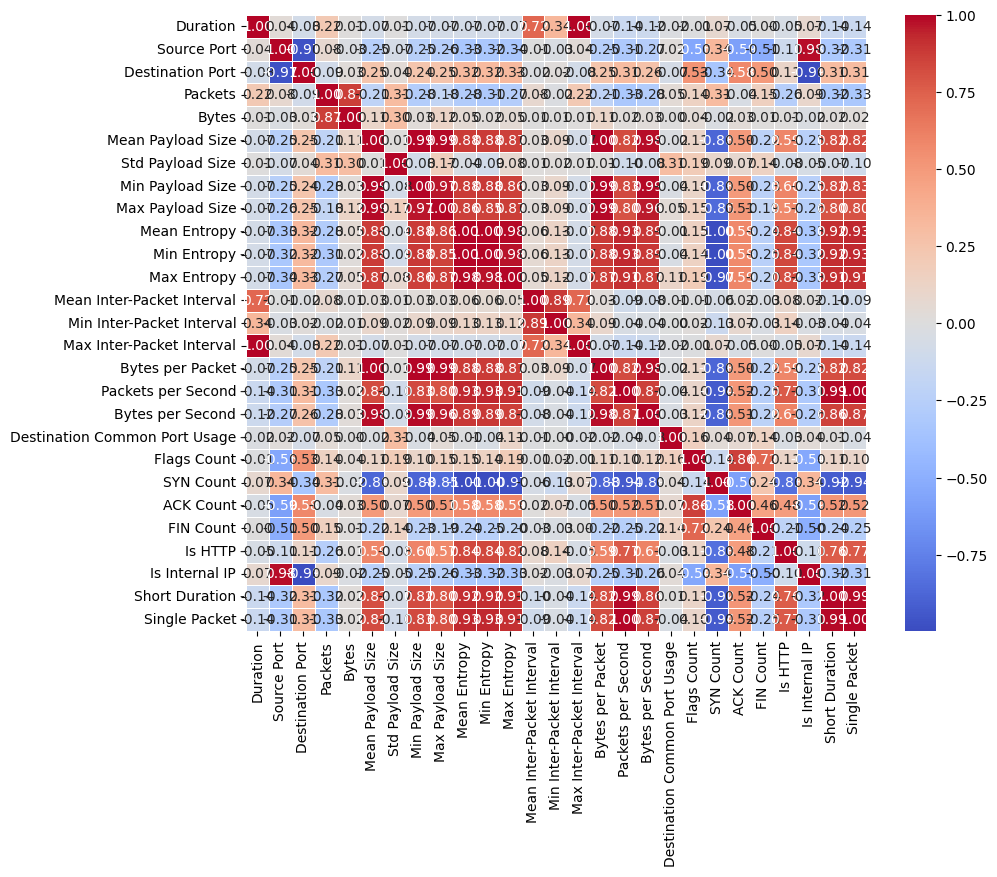

In [14]:
info.numerical_summary()

## Modeling

#### Encoding

In [15]:
encoder = LabelEncoder()

columns_to_encode = ["Protocol", "Flags", "Label", "Direction"]

for column in columns_to_encode:
    df[column] = encoder.fit_transform(df[column])

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

columns_to_impute = [
    "Mean Payload Size",
    "Std Payload Size",
    "Min Payload Size",
    "Max Payload Size",
    "Mean Entropy",
    "Min Entropy",
    "Max Entropy",
    "Mean Inter-Packet Interval",
    "Min Inter-Packet Interval",
    "Max Inter-Packet Interval",
]

df_imputation = df.drop(columns_to_impute, axis=1).copy()

imputer = IterativeImputer(max_iter=10, random_state=42)

for x in columns_to_impute:
    df_imputation[x] = df[x]
    for label in df["Label"].unique():
        label_mask = df_imputation["Label"] == label
        label_df = df_imputation[label_mask].copy()

        label_df[x] = label_df[x].replace(0, np.nan)


        imputed_data = imputer.fit_transform(label_df)

        df_imputation.loc[label_mask, x] = imputed_data[
            :, df_imputation.columns.get_loc(x)
        ]

df = df_imputation.copy()

#### Type Casting

In [17]:
df["Bytes"] = df["Bytes"].astype("float64")
df["Duration"] = df["Duration"].astype("float64")
df["Packets"] = df["Packets"].astype("float64")
df["Flags Count"] = df["Flags Count"].astype("float64")

### Data Splitting

In [18]:
label_column = df["Label"]
dropped_df = df.drop("Label", axis=1)

scaler = StandardScaler()
scaled_dropped_df = scaler.fit_transform(dropped_df.to_numpy())
df = pd.DataFrame(scaled_dropped_df, columns=dropped_df.columns)

df["Label"] = label_column

## Models

### Model Creation and Parameters

In [19]:
#! Model Evaluation
test_size = 0.3
iterations = 30

#! KNN
n_estimators = 7
dt_train_model = RandomForestClassifier(n_estimators=n_estimators)

#! Random Forest
n_estimators = 100  # You can adjust this number as needed
rf_train_model = RandomForestClassifier(n_estimators=n_estimators)

#! Logistic Regression
max_iter = 5000
logreg_model = LogisticRegression(max_iter=max_iter)

### Splitting

In [20]:
df_reset = df.reset_index(drop=True)
X = df_reset.drop("Label", axis=1)
y = df["Label"]

### KNN

In [21]:
dt_normal = prisma.MachineLearning()
dt_normal_metrics, avg_dt_normal_metrics, dt_normal_model = (
    dt_normal.evaluate_model(X, y, test_size, iterations, dt_train_model)
)

Evaluating model: 100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


### Random Forest

In [22]:
rf_normal = prisma.MachineLearning()
(
    rf_normal_metrics,
    avg_rf_normal_metrics,
    rf_normal_model,
) = rf_normal.evaluate_model(X, y, test_size, iterations, rf_train_model)

Evaluating model: 100%|██████████| 30/30 [01:22<00:00,  2.74s/it]


### Logistic Regression

In [23]:
logreg_normal = prisma.MachineLearning()
(
    logreg_normal_metrics,
    avg_logreg_normal_metrics,
    logreg_normal_model,
) = logreg_normal.evaluate_model(X, y, test_size, iterations, logreg_model)

Evaluating model: 100%|██████████| 30/30 [00:09<00:00,  3.21it/s]


### Model Evaluation

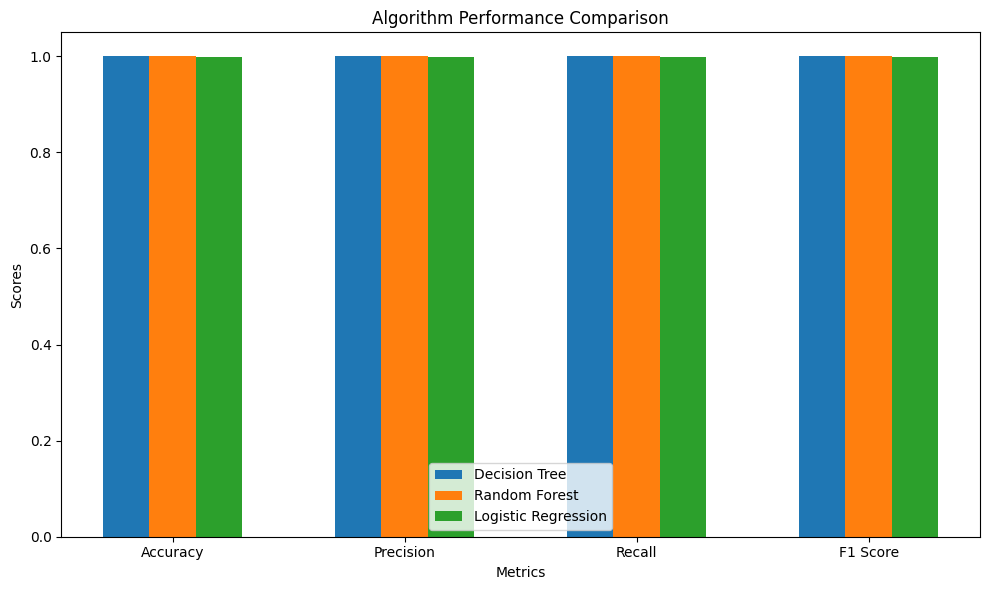

In [24]:
normal_metrics = {"Decision Tree":avg_dt_normal_metrics, "Random Forest":avg_rf_normal_metrics, "Logistic Regression":avg_logreg_normal_metrics}
plot = prisma.Plotting(df)

plot.plot_algorithm_comparison(normal_metrics)

In [25]:
normal_metrics

{'Decision Tree': {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1 Score': 1.0},
 'Random Forest': {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1 Score': 1.0},
 'Logistic Regression': {'Accuracy': 0.998,
  'Precision': 0.998,
  'Recall': 0.998,
  'F1 Score': 0.998}}

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

X_lstm = np.expand_dims(X, axis=1)

# Train-test split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y, test_size=0.2, random_state=42, stratify=y
)

model = Sequential(
    [
        LSTM(
            128,
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
            return_sequences=True,
        ),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(
            y.shape[1] if len(y.shape) > 1 else 1,
            activation="sigmoid",
        ),
    ]
)

# Compile the model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=200,
    batch_size=64,
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

2025-02-01 13:04:48.269293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-01 13:04:48.272951: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-01 13:04:48.281010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738404288.294717   52523 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738404288.298484   52523 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 13:04:48.312893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/200


2025-02-01 13:04:49.833086: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


996/996 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9697 - loss: 0.1281 - val_accuracy: 0.9942 - val_loss: 0.0094
Epoch 2/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9958 - loss: 0.0086 - val_accuracy: 0.9963 - val_loss: 0.0054
Epoch 3/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9967 - loss: 0.0062 - val_accuracy: 0.9967 - val_loss: 0.0044
Epoch 4/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9973 - loss: 0.0055 - val_accuracy: 0.9935 - val_loss: 0.0473
Epoch 5/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9982 - loss: 0.0059 - val_accuracy: 0.9997 - val_loss: 0.0031
Epoch 6/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.9997 - val_loss: 0.0026
Epoch 7/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9988 - loss: 0.0033 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 8/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.999

498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:


<Figure size 800x600 with 0 Axes>

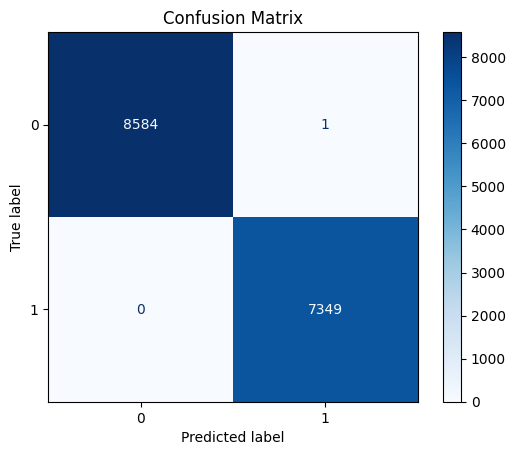

In [29]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)

y_pred_lstm = model.predict(X_test_lstm)

# Convert predictions to binary labels (for binary classification)
y_pred_binary = (y_pred_lstm > 0.5).astype(int).flatten()

print("\nClassification Report:")
report_dict = classification_report(y_test_lstm, y_pred_binary, output_dict=True)

lstm_metrics = {
    "Precision": report_dict["1"]["precision"],  # Precision for class 1 (malicious)
    "Recall": report_dict["1"]["recall"],  # Recall for class 1 (malicious)
    "F1 Score": report_dict["1"]["f1-score"],  # F1-score for class 1 (malicious)
    "Accuracy": accuracy_score(y_test_lstm, y_pred_binary),  # Overall accuracy
}

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_lstm, y_pred_binary)

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [30]:
confusion_matrix(y_test_lstm, y_pred_binary)

array([[8584,    1],
       [   0, 7349]])

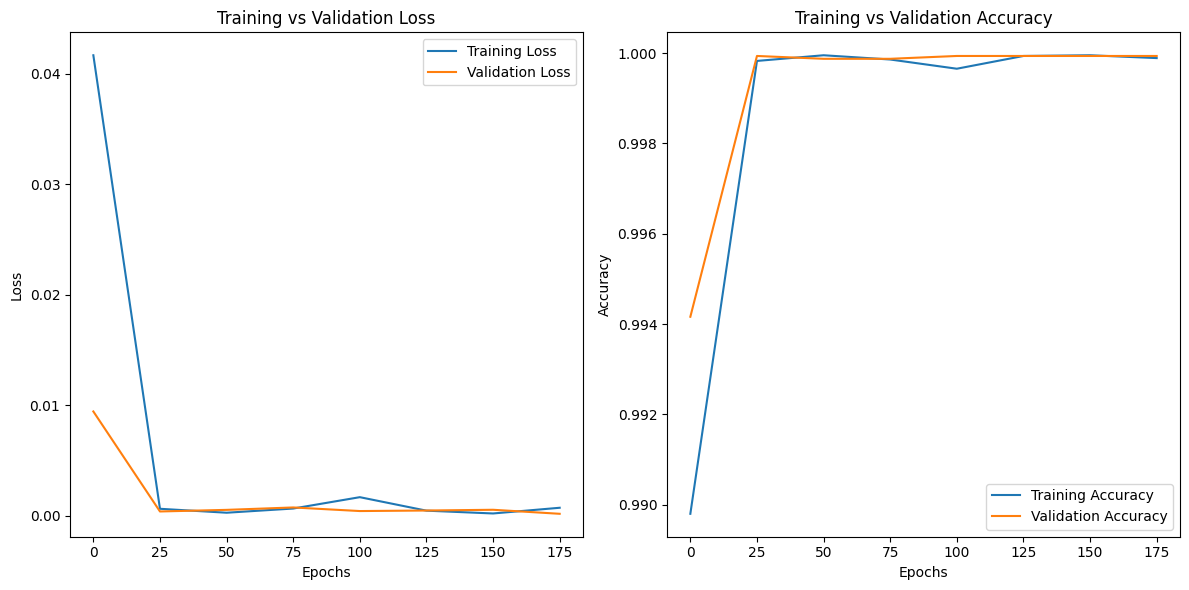

In [28]:
epochs = len(history.history["loss"])
epoch_ticks = np.arange(0, epochs, 25)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_ticks, history.history["loss"][::25], label="Training Loss")
plt.plot(epoch_ticks, history.history["val_loss"][::25], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epoch_ticks)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epoch_ticks, history.history["accuracy"][::25], label="Training Accuracy")
plt.plot(epoch_ticks,history.history["val_accuracy"][::25], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epoch_ticks)
plt.legend()

plt.tight_layout()
plt.show()

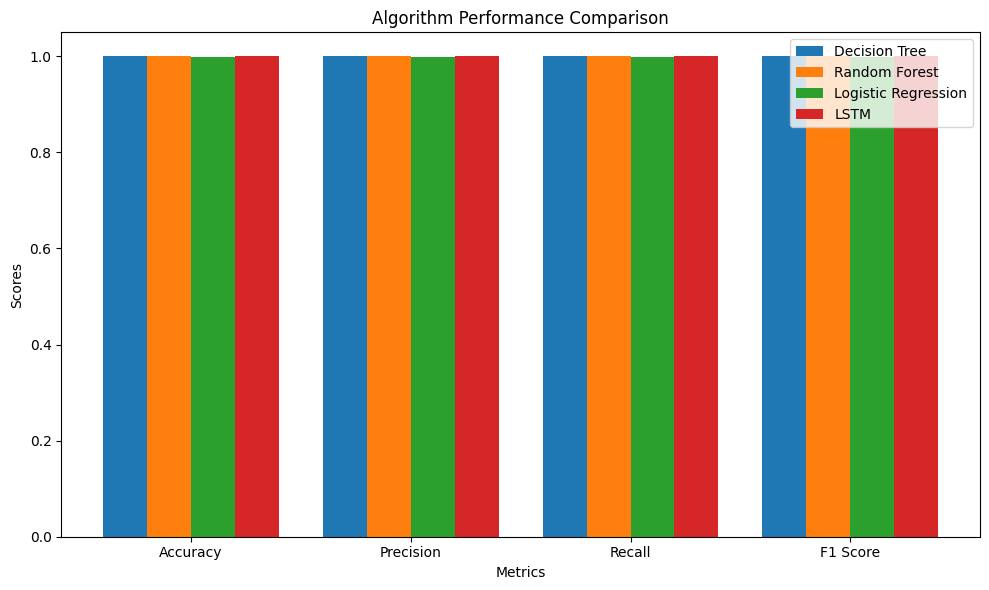

In [31]:
normal_metrics = {
    "Decision Tree": avg_dt_normal_metrics,
    "Random Forest": avg_rf_normal_metrics,
    "Logistic Regression": avg_logreg_normal_metrics,
    "LSTM": lstm_metrics,
}
plot = prisma.Plotting(df)

plot.plot_algorithm_comparison(normal_metrics)

In [32]:
res_df = pd.DataFrame(normal_metrics)
res_df

,Decision Tree,Random Forest,Logistic Regression,LSTM
Accuracy,1.0,1.0,0.998,0.999937
Precision,1.0,1.0,0.998,0.999864
Recall,1.0,1.0,0.998,1.000000
F1 Score,1.0,1.0,0.998,0.999932


In [33]:
epoch_ticks = list(range(0, len(history.history["loss"]), 25))

df_metrics = pd.DataFrame(
    {
        "Epoch": epoch_ticks,
        "Training Loss": history.history["loss"][::25],
        "Validation Loss": history.history["val_loss"][::25],
        "Training Accuracy": history.history["accuracy"][::25],
        "Validation Accuracy": history.history["val_accuracy"][::25],
    }
)

df_metrics

,Epoch,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy
0,0,0.041683,0.009440,0.989801,0.994163
1,25,0.000630,0.000387,0.999827,0.999937
2,50,0.000274,0.000532,0.999953,0.999874
3,75,0.000653,0.000750,0.999859,0.999874
4,100,0.001681,0.000425,0.999655,0.999937
5,125,0.000460,0.000473,0.999937,0.999937
6,150,0.000206,0.000540,0.999953,0.999937
7,175,0.000723,0.000177,0.999890,0.999937
